In [ ]:
import pandas as pd
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# Load The Data

In [ ]:

data_pathes = ['2018-19_timeout_final.csv', '2019-20_timeout_final.csv', 
               '2020-21_timeout_final.csv', '2021-22_timeout_final.csv', 
               '2022-23_timeout_final.csv']
df = pd.DataFrame()
for path in data_pathes:
  season_df = pd.read_csv(path)
  season_df = season_df.drop(columns=['Unnamed: 0'])
  season_df['season'] = path[:4]
  if len(df) == 0:
    df = season_df
  else:
    df = pd.concat([df, season_df])
df.head()

,GAME_ID,TS,T,Y,home_run,SCORE_A,SCORE_B,g_made_home,g_made_road,g_missed_home,...,avg_REB_B,avg_AST_B,avg_STL_B,avg_BLK_B,avg_TOV_B,avg_PF_B,avg_PLUS_MINUS_B,TEAM_ABBREVIATION_A,TEAM_ABBREVIATION_B,season
0,41800406,1900-01-01 00:02:52,0,1,0,101,106,37,37,45,...,42.478261,22.434783,8.043478,4.695652,11.478261,22.608696,5.521739,GSW,TOR,2018
1,41800405,1900-01-01 00:08:02,0,0,0,35,46,11,16,15,...,43.700000,28.500000,7.450000,5.600000,14.450000,23.300000,3.850000,TOR,GSW,2018
2,41800405,1900-01-01 00:04:10,0,0,1,71,77,23,27,35,...,43.700000,28.500000,7.450000,5.600000,14.450000,23.300000,3.850000,TOR,GSW,2018
3,41800404,1900-01-01 00:00:38,0,0,0,66,77,28,26,41,...,42.619048,22.619048,7.952381,4.714286,11.523810,22.857143,5.476190,GSW,TOR,2018
4,41800403,1900-01-01 00:09:02,0,0,1,59,66,19,22,26,...,42.750000,22.250000,7.900000,4.450000,11.400000,22.900000,5.050000,GSW,TOR,2018


In [ ]:
print(f'There are {len(df)} rows in the data frame.')
print()
print('Distarbution of T and Y (withou taking in accuont the possible confounders):')

t_0 = len(df[df['T'] == 0])
t_1 = len(df[df['T'] == 1])
t_0_y_0 = len(df[(df['T'] == 0) & (df['Y'] == 0)])
t_1_y_0 = len(df[(df['T'] == 1) & (df['Y'] == 0)])
t_0_y_1 = len(df[(df['T'] == 0) & (df['Y'] == 1)])
t_1_y_1 = len(df[(df['T'] == 1) & (df['Y'] == 1)])

table = PrettyTable()
table.field_names = ["", "T = 0", "T = 1"]
table.add_row(["Y = 0", str(round(100 * t_0_y_0/t_0, 2)) + '%', str(round(100 * t_1_y_0/t_1, 2)) + '%'])
table.add_row(["Y = 1", str(round(100 * t_0_y_1/t_0, 2)) + '%', str(round(100 * t_1_y_1/t_1, 2)) + '%'])
table.add_row(['Total', t_0, t_1])
print(table)

There are 20678 rows in the data frame.

Distarbution of T and Y (withou taking in accuont the possible confounders):
+-------+--------+-------+
|       | T = 0  | T = 1 |
+-------+--------+-------+
| Y = 0 | 52.23% | 55.4% |
| Y = 1 | 47.77% | 44.6% |
| Total | 18057  |  2621 |
+-------+--------+-------+


Note that when we are not taking into account the possible confounders the distarbutions seems identical

Furthermore, it's apparent that there are far more data points where T is equal to 0 compared to T being equal to 1.

# Check Data Balnce

In [ ]:
team_opponent_df = df.copy()

In [ ]:
for col in team_opponent_df:

  if '_A' in col or '_B' in col:

    curr_name = col[:-2] + '_curr'
    opponent_name = col[:-2] + '_opponent'

    team_opponent_df[curr_name] = team_opponent_df.apply(lambda row: 
                                                         row[col[:-2] + '_A']*row['home_run'] + row[col[:-2] + '_B']*(1 - row['home_run']), axis=1)

    team_opponent_df[opponent_name] = team_opponent_df.apply(lambda row: 
                                                         row[col[:-2] + '_A']*(1 - row['home_run']) + row[col[:-2] + '_B']*row['home_run'], axis=1)
  
  elif '_road' in col or '_home' in col:

    curr_name = col[:-5] + '_curr'
    opponent_name = col[:-5] + '_opponent'

    team_opponent_df[curr_name] = team_opponent_df.apply(lambda row: 
                                                         row[col[:-5] + '_home']*row['home_run'] + row[col[:-5] + '_road']*(1 - row['home_run']), axis=1)

    team_opponent_df[opponent_name] = team_opponent_df.apply(lambda row: 
                                                         row[col[:-5] + '_home']*(1 - row['home_run']) + row[col[:-5] + '_road']*row['home_run'], axis=1)

In [ ]:
team_opponent_df = team_opponent_df[[col for col in team_opponent_df.columns if 'curr' in col or 'opponent' in col] + 
                                    ['home_run', 'T', 'Y', 'season']]
team_opponent_df.head()

,SCORE_curr,SCORE_opponent,g_made_curr,g_made_opponent,g_missed_curr,g_missed_opponent,fta_curr,fta_opponent,rebound_curr,rebound_opponent,...,avg_PF_curr,avg_PF_opponent,avg_PLUS_MINUS_curr,avg_PLUS_MINUS_opponent,TEAM_ABBREVIATION_curr,TEAM_ABBREVIATION_opponent,home_run,T,Y,season
0,106,101,37,37,35,45,24,24,42,49,...,22.608696,23.238095,5.521739,3.714286,TOR,GSW,0,0,1,2018
1,46,35,16,11,11,15,5,15,12,16,...,23.300000,22.772727,3.850000,5.818182,GSW,TOR,0,0,0,2018
2,71,77,23,27,35,27,25,12,36,34,...,22.772727,23.300000,5.818182,3.850000,TOR,GSW,1,0,0,2018
3,77,66,26,28,33,41,19,9,36,43,...,22.857143,23.315789,5.476190,4.736842,TOR,GSW,0,0,0,2018
4,59,66,19,22,26,22,17,15,25,25,...,23.444444,22.900000,5.777778,5.050000,GSW,TOR,1,0,0,2018


In [ ]:
team_opponent_df.to_csv('work_on.csv', index=False)

In [ ]:
col_name_to_humen = {
    'SCORE_curr': 'Team score',
    'SCORE_opponent': 'Opponent team score',
    'g_made_curr': 'Field goals made',
    'g_made_opponent': 'Opponent field goals made',
    'g_missed_curr': 'Field goals missed',
    'g_missed_opponent': 'Opponent field goals missed',
    'fta_curr': 'Free throws attempted',
    'fta_opponent': 'Opponent free throws attempted',
    'rebound_curr': 'Rebounds',
    'rebound_opponent': 'Opponent rebounds',
    'to_curr': 'Turnovers',
    'to_opponent': 'Opponent turnovers',
    'avg_PTS_curr': 'Average points',
    'avg_PTS_opponent': 'Average points by opponent team',
    'avg_FGM_curr': 'Average field goals made',
    'avg_FGM_opponent': 'Average field goals made by opponent team',
    'avg_FGA_curr': 'Average field goals attempted',
    'avg_FGA_opponent': 'Average field goals attempted by opponent team',
    'avg_FG_PCT_curr': 'Average field goal percentage',
    'avg_FG_PCT_opponent': 'Average field goal percentage by opponent team',
    'avg_FG3M_curr': 'Average 3-point field goals made',
    'avg_FG3M_opponent': 'Average 3-point field goals made by opponent team',
    'avg_FG3A_curr': 'Average 3-point field goals attempted',
    'avg_FG3A_opponent': 'Average 3-point field goals attempted by opponent team',
    'avg_FG3_PCT_curr': 'Average 3-point field goal percentage',
    'avg_FG3_PCT_opponent': 'Average 3-point field goal percentage by opponent team',
    'avg_FTM_curr': 'Average free throws made',
    'avg_FTM_opponent': 'Average free throws made by opponent team',
    'avg_FTA_curr': 'Average free throws attempted',
    'avg_FTA_opponent': 'Average free throws attempted by opponent team',
    'avg_FT_PCT_curr': 'Average free throw percentage',
    'avg_FT_PCT_opponent': 'Average free throw percentage by opponent team',
    'avg_OREB_curr': 'Average offensive rebounds',
    'avg_OREB_opponent': 'Average offensive rebounds by opponent team',
    'avg_DREB_curr': 'Average defensive rebounds',
    'avg_DREB_opponent': 'Average defensive rebounds by opponent team',
    'avg_REB_curr': 'Average total rebounds',
    'avg_REB_opponent': 'Average total rebounds by opponent team',
    'avg_AST_curr': 'Average assists',
    'avg_AST_opponent': 'Average assists by opponent team',
    'avg_STL_curr': 'Average steals',
    'avg_STL_opponent': 'Average steals by opponent team',
    'avg_BLK_curr': 'Average blocks',
    'avg_BLK_opponent': 'Average blocks by opponent team',
    'avg_TOV_curr': 'Average turnovers',
    'avg_TOV_opponent': 'Average turnovers by opponent team',
    'avg_PF_curr': 'Average personal fouls',
    'avg_PF_opponent': 'Average personal fouls by opponent team',
    'avg_PLUS_MINUS_curr': 'Average plus/minus rating',
    'avg_PLUS_MINUS_opponent': 'Average plus/minus rating by opponent team',
    'TEAM_ABBREVIATION_curr': 'Team abbreviation',
    'TEAM_ABBREVIATION_opponent': 'Opponent team abbreviation'}

In [ ]:
to_table_df = pd.DataFrame(columns=["Attribute", "Mean For T = 0", "Mean For T = 1", "STD For T = 0", "STD For T = 1", "P-value"])
table = PrettyTable()
table.field_names = ["Attribute", "Mean For T = 0", "Mean For T = 1", "STD For T = 0", "STD For T = 1", "P-value"]
i = 0 
for col in team_opponent_df.columns: 
  
  if col in ['TEAM_ABBREVIATION_curr', 'TEAM_ABBREVIATION_opponent', 'home_run', 'T', 'Y', 'season']:
    continue

  if 'avg' in col:
    continue

  group0 = team_opponent_df[team_opponent_df['T'] == 0][col].dropna()
  group1 = team_opponent_df[team_opponent_df['T'] == 1][col].dropna()

  _, p_value = stats.mannwhitneyu(group0, group1)    

  alpha = (len(team_opponent_df.columns) - 12)
  if p_value < 0.05 / alpha:
    table.add_row([col_name_to_humen[col], round(group0.mean(), 2), round(group1.mean(), 2), round(group0.std(), 2), round(group1.std(), 2), f'*{round(min(1, p_value * alpha), 4)}*'])
    to_table_df.loc[i] = [col_name_to_humen[col], round(group0.mean(), 2), round(group1.mean(), 2), 
                          round(group0.std(), 2), round(group1.std(), 2), f'*{round(min(1, p_value * alpha), 4)}*']
  else:
    table.add_row([col_name_to_humen[col], round(group0.mean(), 2), round(group1.mean(), 2), round(group0.std(), 2), round(group1.std(), 2), round(min(1, p_value * alpha), 4)])
    to_table_df.loc[i] = [col_name_to_humen[col], round(group0.mean(), 2), round(group1.mean(), 2), 
                              round(group0.std(), 2), round(group1.std(), 2), round(min(1, p_value * alpha), 4)]
  i += 1

table.align['Atribute'] = 'l'

print(table)

+--------------------------------+----------------+----------------+---------------+---------------+----------+
|           Attribute            | Mean For T = 0 | Mean For T = 1 | STD For T = 0 | STD For T = 1 | P-value  |
+--------------------------------+----------------+----------------+---------------+---------------+----------+
|           Team score           |     60.72      |     63.71      |      32.8     |     34.07     | *0.0017* |
|      Opponent team score       |      55.7      |     56.99      |     33.07     |     35.42     |    1     |
|        Field goals made        |     22.09      |     23.53      |     11.85     |     12.44     |  *0.0*   |
|   Opponent field goals made    |     20.41      |      21.3      |      12.0     |     13.07     |  0.1672  |
|       Field goals missed       |     23.15      |     24.47      |      14.3     |     15.65     | *0.0323* |
|  Opponent field goals missed   |     24.24      |     25.02      |     14.09     |     14.66     |  0.

In [ ]:
to_table_df.to_latex(index=False, bold_rows=True)

'\\begin{tabular}{lrrrrl}\n\\toprule\n                     Attribute &  Mean For T = 0 &  Mean For T = 1 &  STD For T = 0 &  STD For T = 1 &  P-value \\\\\n\\midrule\n                    Team score &           60.72 &           63.71 &          32.80 &          34.07 & *0.0017* \\\\\n           Opponent team score &           55.70 &           56.99 &          33.07 &          35.42 &        1 \\\\\n              Field goals made &           22.09 &           23.53 &          11.85 &          12.44 &    *0.0* \\\\\n     Opponent field goals made &           20.41 &           21.30 &          12.00 &          13.07 &   0.1672 \\\\\n            Field goals missed &           23.15 &           24.47 &          14.30 &          15.65 & *0.0323* \\\\\n   Opponent field goals missed &           24.24 &           25.02 &          14.09 &          14.66 &   0.6314 \\\\\n         Free throws attempted &           10.76 &           11.19 &           7.95 &           8.63 &        1 \\\\\nOpponen

In [ ]:
table = PrettyTable()
to_table_df = pd.DataFrame(columns=["Attribute", "Mean For T = 0", "Mean For T = 1", "STD For T = 0", "STD For T = 1", "P-value"])
table.field_names = ["Atribute", "Mean For T = 0", "Mean For T = 1", "STD For T = 0", "STD For T = 1", "Pvalue"]

i = 0 
for col in team_opponent_df.columns: 
  
  if col in ['TEAM_ABBREVIATION_curr', 'TEAM_ABBREVIATION_opponent', 'home_run', 'T', 'Y']:
    continue

  if 'PCT' in col:
    continue

  if 'avg' not in col:
    continue

  group0 = team_opponent_df[team_opponent_df['T'] == 0][col].dropna()
  group1 = team_opponent_df[team_opponent_df['T'] == 1][col].dropna()

  _, p_value = stats.ttest_ind(group0, group1)    


  alpha = (len(team_opponent_df.columns) - 12)
  if p_value < 0.05 / alpha:
    table.add_row([col_name_to_humen[col], round(group0.mean(), 2), round(group1.mean(), 2), round(group0.std(), 2), round(group1.std(), 2), f'*{round(min(1, p_value * alpha), 4)}*'])
    to_table_df.loc[i] = [col_name_to_humen[col], round(group0.mean(), 2), round(group1.mean(), 2), 
                        round(group0.std(), 2), round(group1.std(), 2), f'*{round(min(1, p_value * alpha), 4)}*']
  else:
    table.add_row([col_name_to_humen[col], round(group0.mean(), 2), round(group1.mean(), 2), round(group0.std(), 2), round(group1.std(), 2), round(min(1, p_value * alpha), 4)])
    to_table_df.loc[i] = [col_name_to_humen[col], round(group0.mean(), 2), round(group1.mean(), 2), 
                              round(group0.std(), 2), round(group1.std(), 2), round(min(1, p_value * alpha), 4)]
  i += 1

table.align['Atribute'] = 'l'


print(table)

+--------------------------------------------------------+----------------+----------------+---------------+---------------+--------+
| Atribute                                               | Mean For T = 0 | Mean For T = 1 | STD For T = 0 | STD For T = 1 | Pvalue |
+--------------------------------------------------------+----------------+----------------+---------------+---------------+--------+
| Average points                                         |     111.28     |     111.29     |      5.03     |      4.96     |   1    |
| Average points by opponent team                        |     110.93     |     110.77     |      5.12     |      5.0      |   1    |
| Average field goals made                               |     40.79      |     40.82      |      2.03     |      2.01     |   1    |
| Average field goals made by opponent team              |     40.71      |     40.62      |      2.09     |      2.06     |   1    |
| Average field goals attempted                          |    

In [ ]:
to_table_df.to_latex(index=False, bold_rows=True)

'\\begin{tabular}{lrrrrl}\n\\toprule\n                                         Attribute &  Mean For T = 0 &  Mean For T = 1 &  STD For T = 0 &  STD For T = 1 & P-value \\\\\n\\midrule\n                                    Average points &          111.28 &          111.29 &           5.03 &           4.96 &       1 \\\\\n                   Average points by opponent team &          110.93 &          110.77 &           5.12 &           5.00 &       1 \\\\\n                          Average field goals made &           40.79 &           40.82 &           2.03 &           2.01 &       1 \\\\\n         Average field goals made by opponent team &           40.71 &           40.62 &           2.09 &           2.06 &       1 \\\\\n                     Average field goals attempted &           88.62 &           88.64 &           2.99 &           3.02 &       1 \\\\\n    Average field goals attempted by opponent team &           88.67 &           88.73 &           3.04 &           3.06 &       

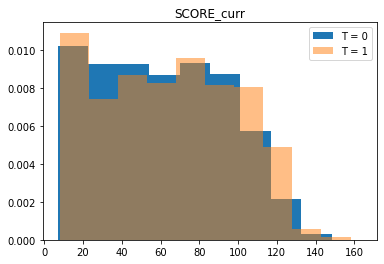

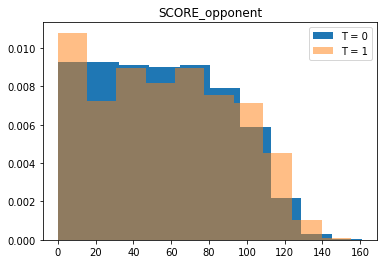

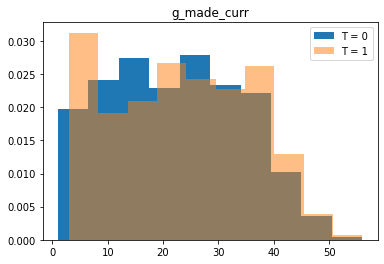

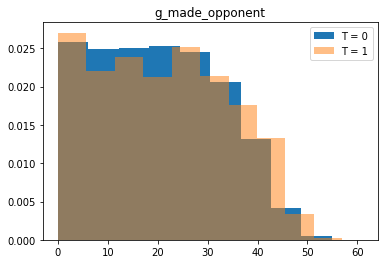

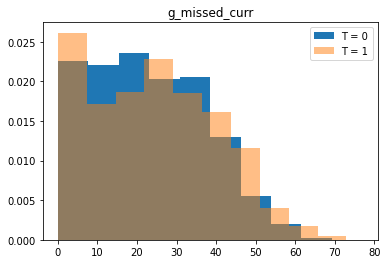

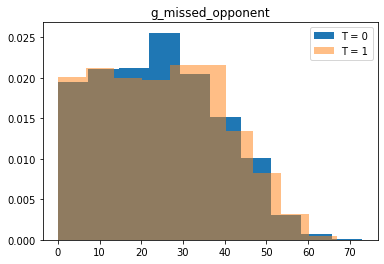

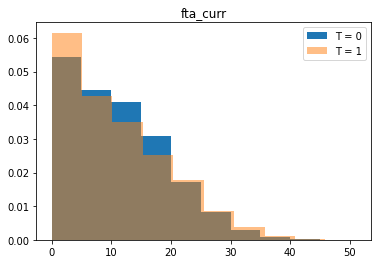

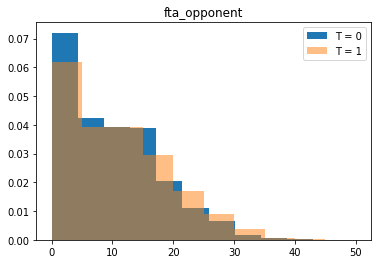

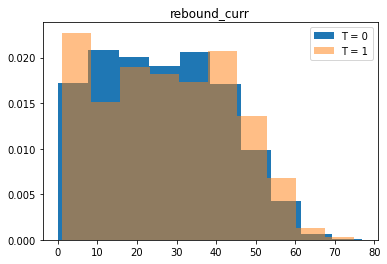

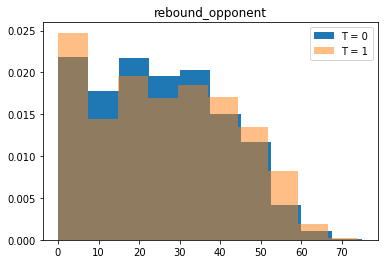

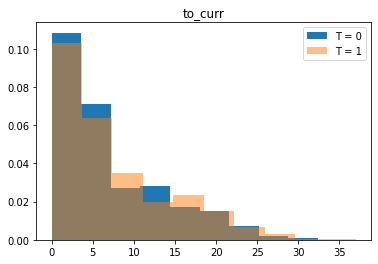

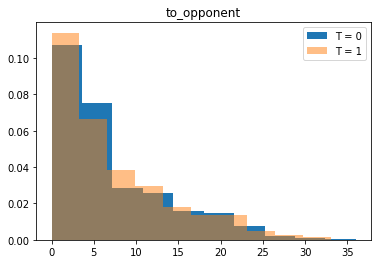

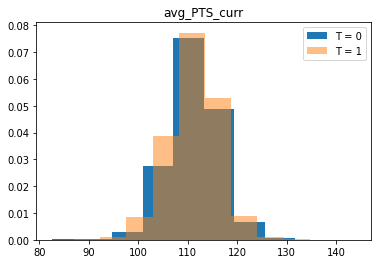

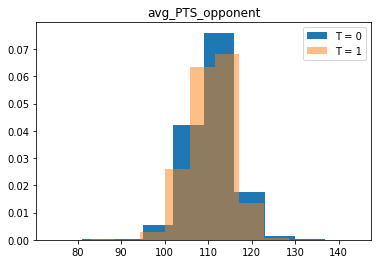

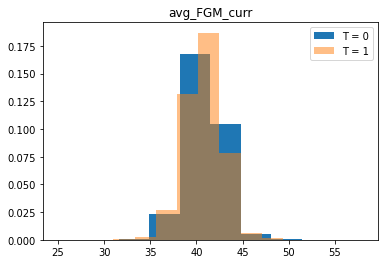

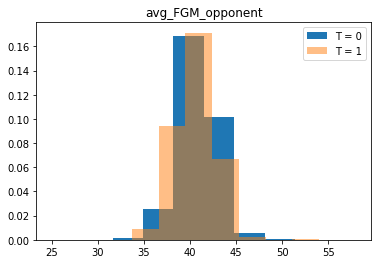

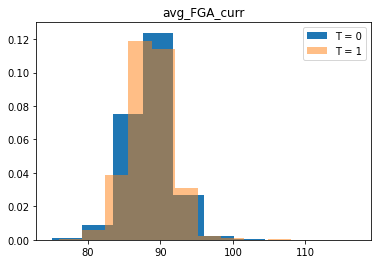

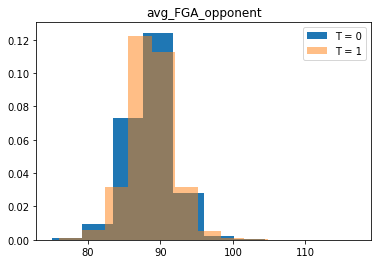

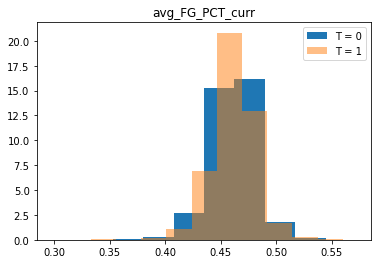

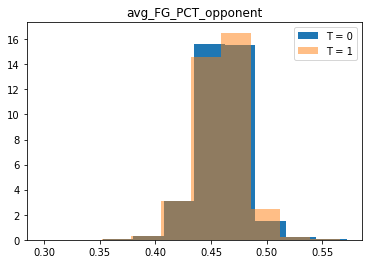

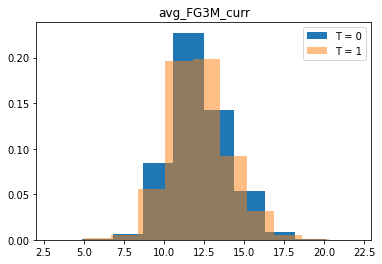

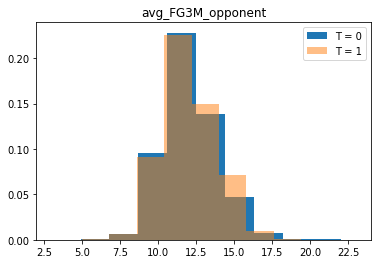

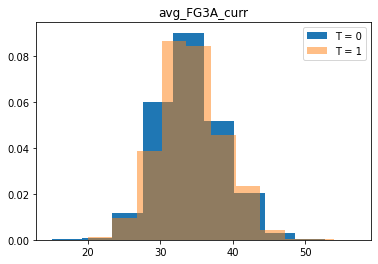

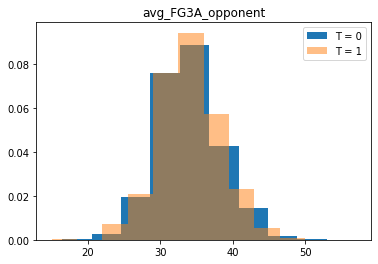

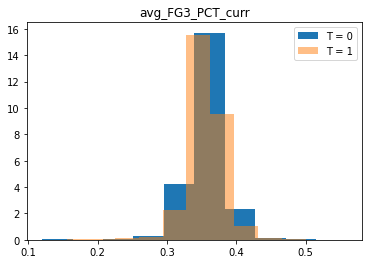

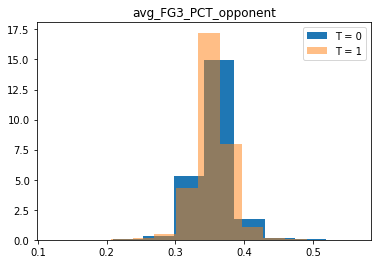

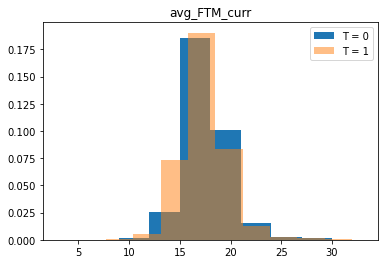

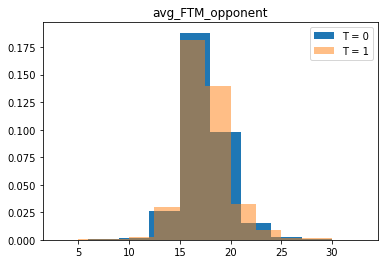

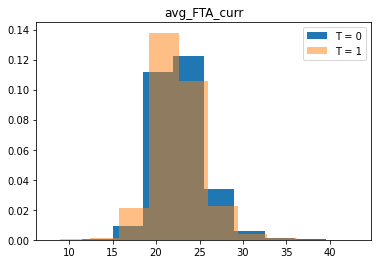

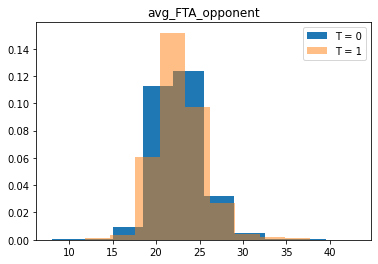

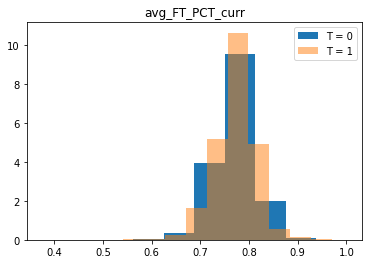

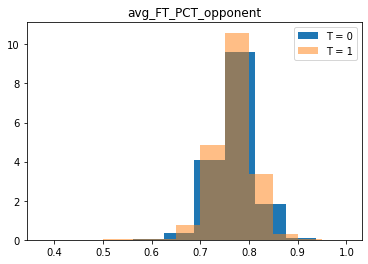

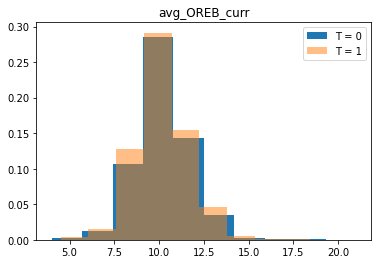

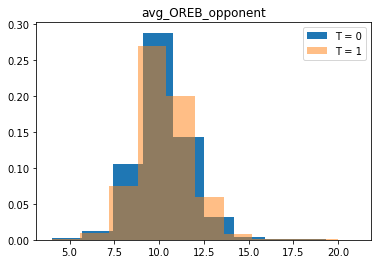

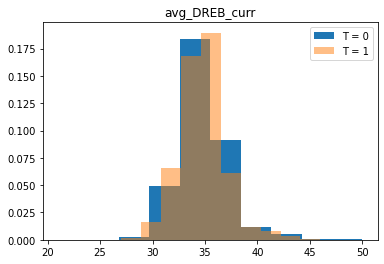

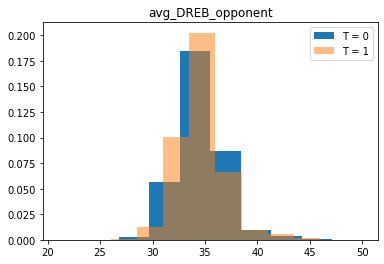

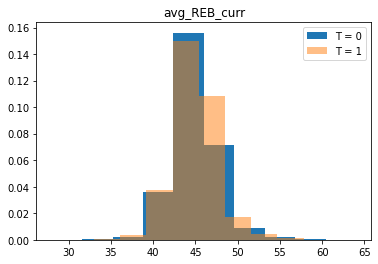

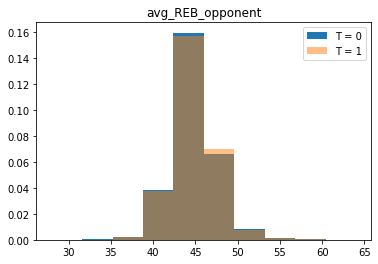

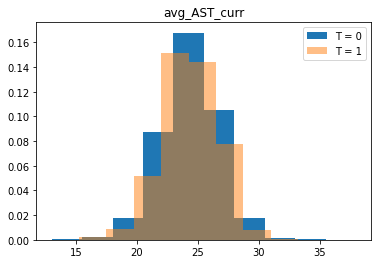

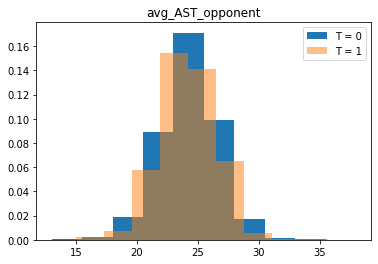

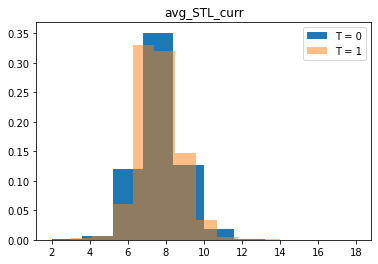

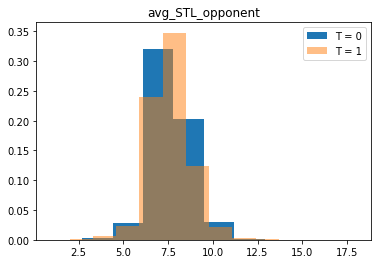

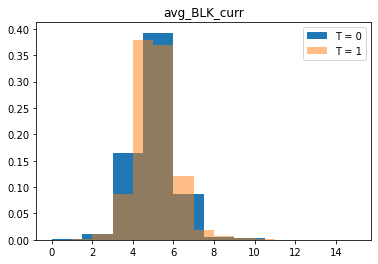

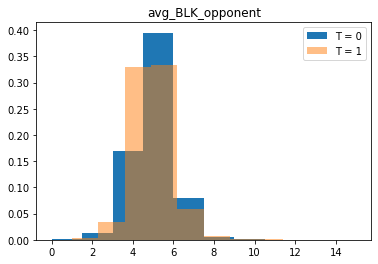

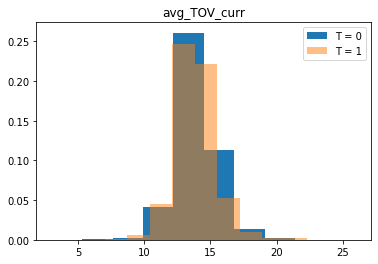

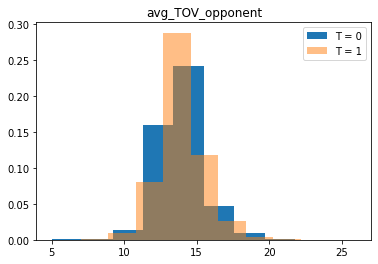

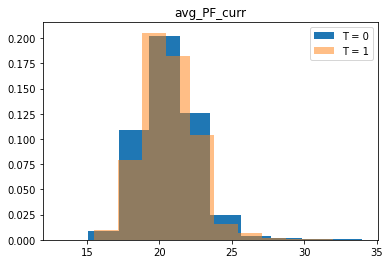

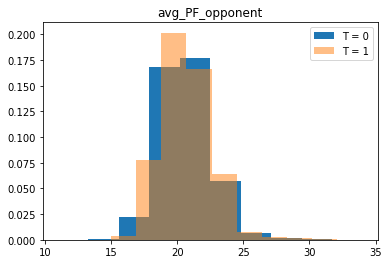

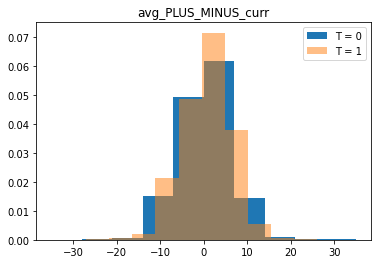

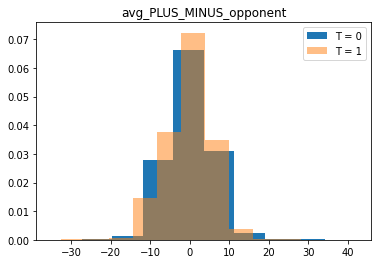

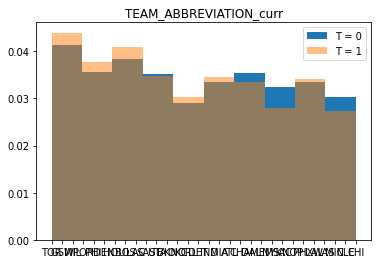

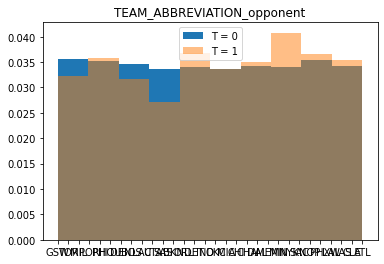

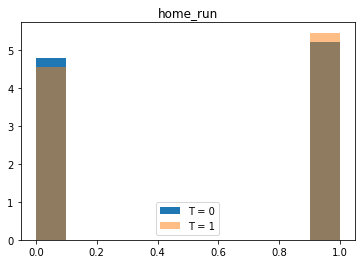

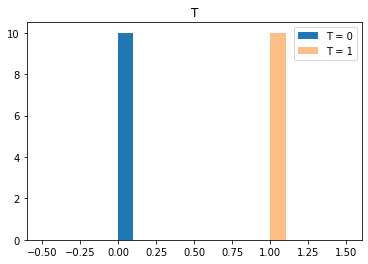

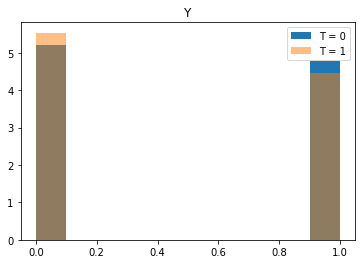

In [ ]:

# col_to_title = {'avg_FGM_A': 'Home Team Average Field Goal Distribution Until Game',
#                 'to_road': 'Road Team Turnover Distribution Until Strike Begins',
#                 'avg_FGM_B': 'Road Team Average Field Goal Distribution Until Game',
#                 'to_home': 'Home Team Turnover Distribution Until Strike Begins'}

for col in team_opponent_df.columns: # ['avg_FGM_A', 'to_road', 'avg_FGM_B', 'to_home']:

  plt.title(col)

  plt.hist(team_opponent_df[team_opponent_df['T'] == 0][col], label='T = 0', density=True)
  plt.hist(team_opponent_df[team_opponent_df['T'] == 1][col], label='T = 1', density=True, alpha=0.5)
  plt.legend()
  plt.show()


# plot line

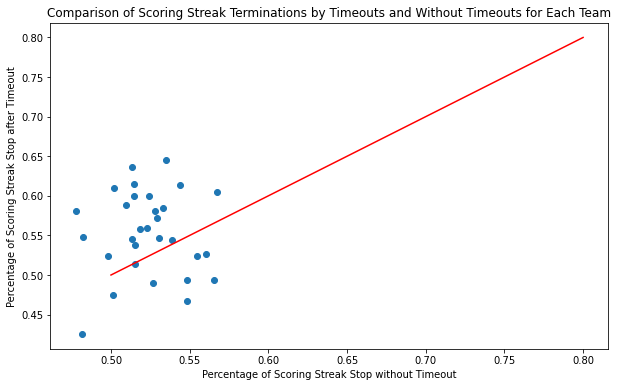

In [ ]:

point_x = []
point_y = []

for team in df['TEAM_ABBREVIATION_A'].unique():
  # print(team)

  by_team_df = df.copy()
  by_team_df['by_team'] = by_team_df.apply(lambda x: x['TEAM_ABBREVIATION_A'] if x['home_run'] == 1 else x['TEAM_ABBREVIATION_B'], axis=1)
  by_team_df = by_team_df[by_team_df['by_team'] == team]

  t_0 = len(by_team_df[by_team_df['T'] == 0])
  t_1 = len(by_team_df[by_team_df['T'] == 1])
  t_0_y_0 = len(by_team_df[(by_team_df['T'] == 0) & (by_team_df['Y'] == 0)])
  t_1_y_0 = len(by_team_df[(by_team_df['T'] == 1) & (by_team_df['Y'] == 0)])
  t_0_y_1 = len(by_team_df[(by_team_df['T'] == 0) & (by_team_df['Y'] == 1)])
  t_1_y_1 = len(by_team_df[(by_team_df['T'] == 1) & (by_team_df['Y'] == 1)])

  point_x.append(t_0_y_0/t_0)
  point_y.append(t_1_y_0/t_1)

plt.figure(figsize=(10, 6))

plt.title('Comparison of Scoring Streak Terminations by Timeouts and Without Timeouts for Each Team')
plt.xlabel('Percentage of Scoring Streak Stop without Timeout')
plt.ylabel('Percentage of Scoring Streak Stop after Timeout')
plt.scatter(point_x, point_y)
plt.plot(np.arange(0.5, 0.85, step=0.1), np.arange(0.5, 0.85, step=0.1), color='r')
plt.show()

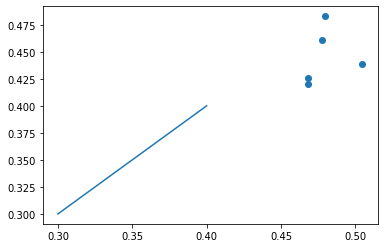

In [ ]:

point_x = []
point_y = []

for team in df['season'].unique():
  # print(team)

  by_team_df = df.copy()
  by_team_df = by_team_df[by_team_df['season'] == team]

  t_0 = len(by_team_df[by_team_df['T'] == 0])
  t_1 = len(by_team_df[by_team_df['T'] == 1])
  t_0_y_0 = len(by_team_df[(by_team_df['T'] == 0) & (by_team_df['Y'] == 0)])
  t_1_y_0 = len(by_team_df[(by_team_df['T'] == 1) & (by_team_df['Y'] == 0)])
  t_0_y_1 = len(by_team_df[(by_team_df['T'] == 0) & (by_team_df['Y'] == 1)])
  t_1_y_1 = len(by_team_df[(by_team_df['T'] == 1) & (by_team_df['Y'] == 1)])

  point_x.append(t_0_y_1/t_0)
  point_y.append(t_1_y_1/t_1)
plt.scatter(point_x, point_y)
plt.plot(np.arange(0.3, 0.4, step=0.1), np.arange(0.3, 0.4, step=0.1))
plt.show()

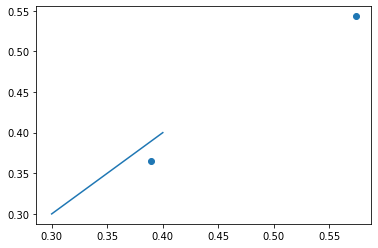

In [ ]:

point_x = []
point_y = []

for team in df['home_run'].unique():
  # print(team)

  by_team_df = df.copy()
  by_team_df = by_team_df[by_team_df['home_run'] == team]

  t_0 = len(by_team_df[by_team_df['T'] == 0])
  t_1 = len(by_team_df[by_team_df['T'] == 1])
  t_0_y_0 = len(by_team_df[(by_team_df['T'] == 0) & (by_team_df['Y'] == 0)])
  t_1_y_0 = len(by_team_df[(by_team_df['T'] == 1) & (by_team_df['Y'] == 0)])
  t_0_y_1 = len(by_team_df[(by_team_df['T'] == 0) & (by_team_df['Y'] == 1)])
  t_1_y_1 = len(by_team_df[(by_team_df['T'] == 1) & (by_team_df['Y'] == 1)])

  point_x.append(t_0_y_1/t_0)
  point_y.append(t_1_y_1/t_1)
plt.scatter(point_x, point_y)
plt.plot(np.arange(0.3, 0.4, step=0.1), np.arange(0.3, 0.4, step=0.1))
plt.show()